# Testing IL
In this notebook we will compare the IL of the implemented AMM to theory.


## Simulation Setup

In [1]:
import ipywidgets as widgets


class Seed:  # I know this looks dumb. not my fault
    random_seed = 1
    
print("Random Seed")
seed_input = widgets.IntText(
    value=Seed.random_seed,
    step=1,
    description='',
    disabled=False
)

output = widgets.Output()
display(seed_input, output)

def on_value_change(change):
    with output:
        Seed.random_seed = change['new']

seed_input.observe(on_value_change, names='value')

Random Seed


IntText(value=1)

Output()

In [2]:
# Dependencies
import pandas
import matplotlib.pyplot
from model.modular_amm.amm import Asset, WorldState
from model.modular_amm.omnipool_amm import OmnipoolAgent, OmniPool, OmnipoolTradeStrategies
import random

# Experiments
from model import run, plot_utils, init_utils

random.seed(Seed.random_seed)

assets = [
    Asset(name='LRNA', price=0.4),
    Asset(name='HDX', price=0.08),
    Asset(name='USD', price=1),
    Asset(name='ETH', price=3000),
    Asset(name='DOGE', price=0.001)
]
omnipool = (
    OmniPool(
        tvl_cap_usd=10000000,
        lrna_fee=0.001,
        asset_fee=0.001,
        preferred_stablecoin='USD'
    ).initializeAssetList(assets)
    .add_lrna_pool('HDX', 1000000)
    .add_lrna_pool('USD', 100000)
    .add_lrna_pool('ETH', 10000)
    .add_lrna_pool('DOGE', 10000000)
)
agents = {
    "trader": OmnipoolAgent(
        name='trader',
        trade_strategy=OmnipoolTradeStrategies.random_swaps
    )
    .add_position('DOGE', 100000)
    .add_position('ETH', 10),
    
    "LP": OmnipoolAgent(name='liquidity provider')
    .add_liquidity(omnipool, 'HDX', 10000)
    .add_liquidity(omnipool, 'ETH', 100),
    
    "arbitrager": OmnipoolAgent(name='arbitrager')
    .add_position('HDX', 10000)
    .add_position('ETH', 100)
    .add_position('DOGE', 100000)
    .add_position('USD', 10000)
}

worldState = WorldState(
    assets=assets,
    exchange=omnipool,
    agents=agents
)

timesteps = 5000
state = {'WorldState': worldState}
config_dict = {
    'N': 1,  # number of monte carlo runs
    'T': range(timesteps),  # number of timesteps - 147439 is the length of uniswap_events
    'M': {'timesteps': [timesteps]},  # simulation parameters
}

pandas.options.mode.chained_assignment = None  # default='warn'
pandas.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (5000, 1, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 2.86s


In [3]:
from model import processing
rdf, agent_df = processing.postprocessing(events)


In [4]:
%matplotlib inline



In [5]:
rdf.head(20)  # Todo: delete

,timestep,L,simulation,R-0,R-1,R-2,R-3,Q-0,Q-1,Q-2,Q-3,B-0,B-1,B-2,B-3,S-0,S-1,S-2,S-3
0,0,0,0,1000000,100000,10000.00,10000000.00,200000.00,250000.00,75000000.00,25000.00,1000000,100000,10000,10000000,1000000,100000,10000,10000000
1,1,0,0,1000000,100000,10000.00,10000000.00,200000.00,250000.00,75000000.00,25000.00,1000000,100000,10000,10000000,1000000,100000,10000,10000000
2,2,0,0,1000000,100000,9999.98,10049543.51,200000.12,250000.00,75000123.12,24876.75,1000000,100000,10000,10000000,1000000,100000,10000,10000000
3,3,0,0,1000000,100000,9999.98,10049543.51,200000.12,250000.00,75000123.12,24876.75,1000000,100000,10000,10000000,1000000,100000,10000,10000000
4,4,0,0,1000000,100000,9999.98,10054279.33,200000.13,250000.00,75000134.83,24865.03,1000000,100000,10000,10000000,1000000,100000,10000,10000000
5,5,0,0,1000000,100000,10004.32,4366079.39,200032.64,250000.00,74967632.98,57334.38,1000000,100000,10000,10000000,1000000,100000,10000,10000000
6,6,0,0,1000000,100000,10005.83,3646486.29,200043.98,250000.00,74956293.78,68662.24,1000000,100000,10000,10000000,1000000,100000,10000,10000000
7,7,0,0,1000000,100000,10005.83,3646486.29,200043.98,250000.00,74956293.78,68662.24,1000000,100000,10000,10000000,1000000,100000,10000,10000000
8,8,0,0,1000000,100000,10005.48,3790542.34,200046.59,250000.00,74958900.62,66052.79,1000000,100000,10000,10000000,1000000,100000,10000,10000000
9,9,0,0,1000000,100000,10008.58,2806262.02,200069.81,250000.00,74935678.42,89251.77,1000000,100000,10000,10000000,1000000,100000,10000,10000000


In [6]:
agent_df.tail(20)  # TODO: delete

,simulation,subset,run,substep,timestep


## Analysis

[0]


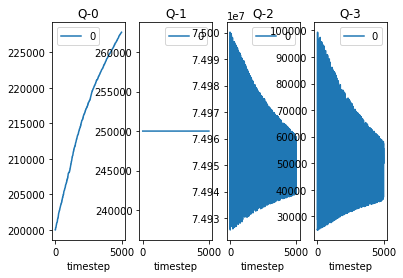

In [7]:
var_list = ['R', 'Q']
plot_utils.plot_vars(rdf, var_list)


In [9]:
var_list = ['r', 'q']
trader_df = agent_df[agent_df['agent_label'] == 'trader']
plot_utils.plot_vars(trader_df, var_list)


KeyError: 'agent_label'

In [ ]:
# merge agent_df, rdf to one df on timesteps, run, etc

merged_df = pandas.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])

In [ ]:
# add IL column to agent DF, where val_hold is calculated using initial holdings from agent_d
#val hold: withdraw liquidity at t=0, calculate value with prices at t
#val pool: withdraw liquidity at t, calculate value with prices at t


merged_df['P-0'] = merged_df.apply(lambda x: x['Q-0']/x['R-0'], axis=1)
merged_df['P-1'] = merged_df.apply(lambda x: x['Q-1']/x['R-1'], axis=1)
merged_df['val_pool'] = merged_df.apply(lambda x: processing.val_pool(x), axis=1)
withdraw_agent_d = processing.get_withdraw_agent_d(initial_values, agent_d)
print(withdraw_agent_d)
merged_df['val_hold'] = merged_df.apply(lambda x: processing.val_hold(x, withdraw_agent_d), axis=1)
merged_df['IL'] = merged_df.apply(lambda x: x['val_pool']/x['val_hold'] - 1, axis=1)
merged_df['pool_val'] = merged_df.apply(lambda x: processing.pool_val(x), axis=1)
#merged_df['pool_loss'] = merged_df.apply(lambda x: x['pool_val']/2000000 - 1, axis=1)

merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val', 'p-0']].tail()


# complot_utilste val hold column


# complot_utilste val pool column

# complot_utilste IL

# plot Impermanent loss
# 

In [ ]:
merged_df[merged_df['agent_label'] == 'LP2'][['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val']].head(20)


In [ ]:
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
LP1_merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val']].head(50)

## IL over time



In [ ]:
var_list = ['pool_val', 'val_pool', 'val_hold', 'IL']
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
plot_utils.plot_vars(LP1_merged_df, var_list)

## IL as a function of price movement

### Theory

On a price move from $p_i^Q \to k p_i^Q$, LP is entitled to $k\frac{\sqrt{k}}{k+1}$ of the *original value* of the matched pool.
$$
Val_{hold} = k p_i^Q R_i\\
Val_{pool} = \frac{\sqrt{k}k}{k+1} 2Q_i = \left(\frac{2\sqrt{k}k}{k+1}\right) p_i^Q R_i
$$

### $Val_{hold}$

In [ ]:
def val_hold_func(P, R):
    return P * R

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = pyplot.subplot(131, title='P-0/val_hold')
LP1_merged_df[['val_hold','P-0']].astype(float).plot(ax=ax, y=['val_hold'], x='P-0', label=[])

#ax = pyplot.subplot(132, title='Theoretical')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: val_hold_func(x['P-0'], LP1['omniR1']), axis=1)
ax.plot(x,y, label='Theory')

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### $Val_{Pool}$

In [ ]:
def val_pool_func(P, P_init, R):
    k = P/P_init
    return 2 * k * math.sqrt(k) / (k + 1) * P_init * R

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = pyplot.subplot(131, title='P-0/val_pool')
LP1_merged_df[['val_pool','P-0']].astype(float).plot(ax=ax, y=['val_pool'], x='P-0', label=[])

#ax = pyplot.subplot(132, title='Theoretical')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], initial_values['P'][0], LP1['omniR1']), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], initial_values['P'][0], x['R-0']), axis=1)
ax.plot(x, y, label='Theory')

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### Impermanent Loss

In [ ]:
def IL_func(P, P_init, R):
    return val_pool_func(P, P_init, R)/val_hold_func(P, R) - 1

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = pyplot.subplot(131, title='P-0/IL')
LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])

#ax = pyplot.subplot(132, title='Theoretical')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: IL_func(x['P-0'], initial_values['P'][0], LP1['omniR1']), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], initial_values['P'][0], x['R-0']), axis=1)
ax.plot(x, y, label='Theory')

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

In [ ]:
LP1_merged_df[['val_pool', 'val_hold', 'R-0', 's-0', 'S-0', 'B-0', 'P-0', 'p-0']].tail()